# Weather data analysis with taxi

In [1]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, sum, avg, format_number, mean, month, year, unix_timestamp, date_format, when, round, expr, weekofyear, log

warnings.filterwarnings('ignore')

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

23/08/20 19:24:07 WARN Utils: Your hostname, LAPTOP-D9335T9D resolves to a loopback address: 127.0.1.1; using 192.168.0.77 instead (on interface wifi0)
23/08/20 19:24:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/20 19:24:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Reading taxi data

In [3]:
tlc_sdf = spark.read.parquet('../data/curated/taxi_data/*')

Select feature of interest

In [4]:
features = ["tip_amount", "hour", 'pickup_day']
taxi_sdf = tlc_sdf.select(features)
# again apply the log transformation to tip amount 
taxi_sdf = taxi_sdf.withColumn('tip_amount_log', log(taxi_sdf['tip_amount']))
taxi_sdf = taxi_sdf.drop(*['tip_amount'])


#### group the taxi data by hour time 

In [5]:
# Group by the day and hour 
gb_taxi = taxi_sdf.groupBy("pickup_day","hour").agg(
    F.count("*").alias("trip_count"),
    F.avg("tip_amount_log").alias("average_tip_amount_log")
)
# round to 3 decimal place
gb_taxi = gb_taxi.withColumn(
    "average_tip_amount_log", round(F.col("average_tip_amount_log"), 4)
)

#### Now import the hourly weather data 

In [6]:
weather = spark.read.parquet('../data/curated/weather_data/*')

## Examine teh distribution of the feature value in weather data

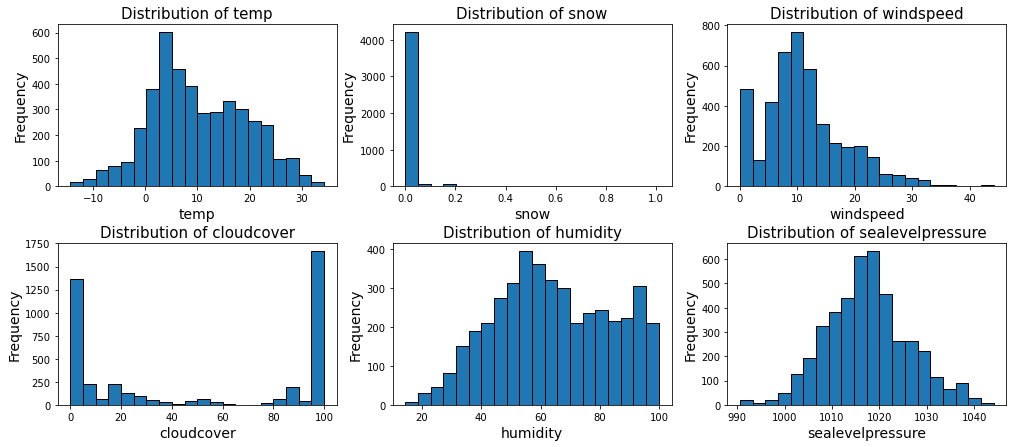

In [7]:
# now plot the data again 
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(17, 7),gridspec_kw={'hspace': 0.35, 'wspace': 0.2})
fig.tight_layout()

columns_to_plot = ['temp', 'snow','windspeed', 'cloudcover', 'humidity', 'sealevelpressure']

# Loop through each column and plot its distribution in a subplot
for i, column in enumerate(columns_to_plot):
    
    # Convert the filtered data to a Pandas DataFrame for plotting
    pandas_data = weather.select(column).toPandas()

    # Plot the histogram in the corresponding subplot
    ax = axs[i // num_cols, i % num_cols]
    ax.hist(pandas_data[column], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {column}',fontsize=15)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
# save to plots folder
output_image_path = "../plots/weather_distribution.png"
plt.savefig(output_image_path)


In [8]:
weather = weather.withColumn('log(cloudcover)', log(weather['cloudcover']+1)) # add 1 to avoid zero values for log 
weather = weather.withColumn('log(windspeed)', log(weather['windspeed']+1))
weather = weather.drop(*['cloudcover'])
weather = weather.drop(*['windspeed'])

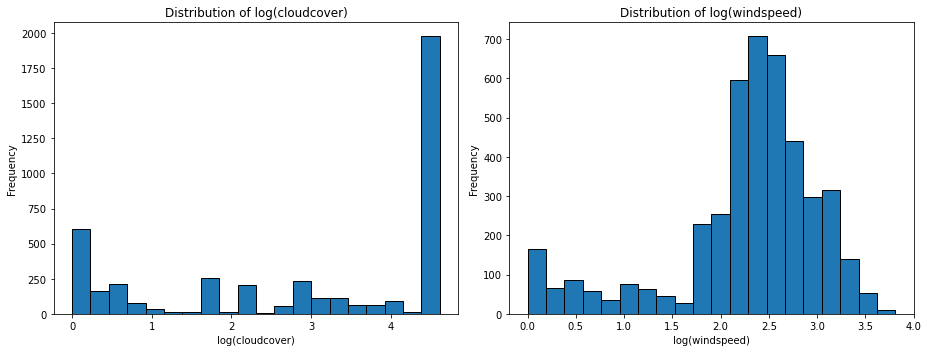

In [9]:
# Log-transform the specified columns
columns= ['log(cloudcover)', 'log(windspeed)']
pandas_data = weather.select(columns).toPandas()

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
plt.tight_layout()

# Plot Average Trip Duration
axs[0].hist(pandas_data['log(cloudcover)'], bins=20, edgecolor='black')
axs[0].set_title("Distribution of log(cloudcover)")
axs[0].set_xlabel("log(cloudcover)")
axs[0].set_ylabel('Frequency')


# Plot Average Tip Amount
axs[1].hist(pandas_data['log(windspeed)'], bins=20, edgecolor='black')
axs[1].set_title("Distribution of log(windspeed)")
axs[1].set_xlabel("log(windspeed)")
axs[1].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()

# Save the plot to an image file
output_image_path = "../plots/log_transformed_distribution.png"
plt.savefig(output_image_path)

# Show the plot
plt.show()


#### Examine feature snow 
check how many instance contains zero value 

In [10]:
zero_snow_count = weather.filter(weather["snow"] == 0).count()
print("number of zeros: %d", zero_snow_count)
print("total instance: %d", weather.count())
print("that is total %d % of data contains zero value for snow", zero_snow_count/weather.count())

number of zeros: %d 4154
total instance: %d 4319
that is total %d % of data contains zero value for snow 0.9617967122018986


Since large significant number of data is zero, we will not consider snow attribute in our analysis

In [11]:
weather = weather.drop(*['snow'])

### join the weather data with hourly taxi data 

In [12]:
# Join the two data using the hour time 
# also rename to sample for convenient 
merged_sdf = gb_taxi.join(weather, (gb_taxi["pickup_day"] == weather["date"]) & (gb_taxi["hour"] == weather["hour_of_the_day"]), "inner")

# Remove one of the duplicate hour
merged_sdf = merged_sdf.drop("hour_of_the_day", 'date')


In [13]:
merged_sdf

pickup_day,hour,trip_count,average_tip_amount_log,temp,feelslike,humidity,sealevelpressure,conditions,day_of_the_week,log(cloudcover),log(windspeed)
2018-01-14,10,8122,0.5954,-5.8,-10.5,56.47,1038.0,Clear,Weekend,0.4054651081081644,2.4849066497880004
2018-01-15,13,9839,0.7136,-1.2,-7.0,65.8,1035.2,Clear,Weekday,1.7749523509116738,3.1441522786722644
2018-01-15,22,7703,0.8844,-2.9,-7.9,77.34,1033.1,Clear,Weekday,0.1823215567939546,2.7536607123542622
2018-01-25,19,15556,0.7605,-0.5,-4.8,26.19,1032.9,Clear,Weekday,0.0,2.714694743820879
2018-01-18,22,14365,0.8414,-2.6,-7.5,52.48,1018.6,Clear,Weekday,0.0,2.747270914255491
2018-01-16,22,10452,0.8204,2.1,-1.6,85.25,1028.5,Clear,Weekday,1.1314021114911006,2.72785282839839
2018-01-20,17,11077,0.718,9.2,7.6,41.4,1013.1,Partially cloudy,Weekend,3.2108436531709366,2.4336133554004498
2018-01-09,8,12645,0.6598,-0.6,-4.2,81.58,1019.7,Clear,Weekday,0.1823215567939546,2.4849066497880004
2018-01-15,9,7829,0.6575,-5.1,-13.2,73.55,1038.5,Clear,Weekday,0.1823215567939546,3.459466289786131
2018-01-16,6,5806,0.6263,-2.2,-6.2,87.51,1032.6,Overcast,Weekday,4.61512051684126,2.4932054526026954


##### convert the categorical to numeric to examine the correlation 

In [14]:
# Convert the categorical features into numerical values using StringIndexer
indexer_conditions = StringIndexer(inputCol="conditions", outputCol="conditions_index")
indexer_day_of_week = StringIndexer(inputCol="day_of_the_week", outputCol="day_of_week_index")

indexed_df = indexer_conditions.fit(merged_sdf).transform(merged_sdf)
indexed_df = indexer_day_of_week.fit(indexed_df).transform(indexed_df)

# Calculate the correlation matrix for all attributes
feature_columns = ["conditions_index", "day_of_week_index", "hour", "trip_count", 'temp','humidity', 'sealevelpressure','log(cloudcover)', 'log(windspeed)']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vectorized_df = assembler.transform(indexed_df)

In [15]:
vectorized_df

pickup_day,hour,trip_count,average_tip_amount_log,temp,feelslike,humidity,sealevelpressure,conditions,day_of_the_week,log(cloudcover),log(windspeed),conditions_index,day_of_week_index,features
2018-01-14,10,8122,0.5954,-5.8,-10.5,56.47,1038.0,Clear,Weekend,0.4054651081081644,2.4849066497880004,0.0,1.0,"[0.0,1.0,10.0,812..."
2018-01-15,13,9839,0.7136,-1.2,-7.0,65.8,1035.2,Clear,Weekday,1.7749523509116738,3.1441522786722644,0.0,0.0,"[0.0,0.0,13.0,983..."
2018-01-15,22,7703,0.8844,-2.9,-7.9,77.34,1033.1,Clear,Weekday,0.1823215567939546,2.7536607123542622,0.0,0.0,"[0.0,0.0,22.0,770..."
2018-01-25,19,15556,0.7605,-0.5,-4.8,26.19,1032.9,Clear,Weekday,0.0,2.714694743820879,0.0,0.0,"[0.0,0.0,19.0,155..."
2018-01-18,22,14365,0.8414,-2.6,-7.5,52.48,1018.6,Clear,Weekday,0.0,2.747270914255491,0.0,0.0,"[0.0,0.0,22.0,143..."
2018-01-16,22,10452,0.8204,2.1,-1.6,85.25,1028.5,Clear,Weekday,1.1314021114911006,2.72785282839839,0.0,0.0,"[0.0,0.0,22.0,104..."
2018-01-20,17,11077,0.718,9.2,7.6,41.4,1013.1,Partially cloudy,Weekend,3.2108436531709366,2.4336133554004498,2.0,1.0,"[2.0,1.0,17.0,110..."
2018-01-09,8,12645,0.6598,-0.6,-4.2,81.58,1019.7,Clear,Weekday,0.1823215567939546,2.4849066497880004,0.0,0.0,"[0.0,0.0,8.0,1264..."
2018-01-15,9,7829,0.6575,-5.1,-13.2,73.55,1038.5,Clear,Weekday,0.1823215567939546,3.459466289786131,0.0,0.0,"[0.0,0.0,9.0,7829..."
2018-01-16,6,5806,0.6263,-2.2,-6.2,87.51,1032.6,Overcast,Weekday,4.61512051684126,2.4932054526026954,1.0,0.0,"[1.0,0.0,6.0,5806..."


In [16]:
# Calculate the correlation matrix
corr_matrix = Correlation.corr(vectorized_df, "features").head()

# Extract the correlation matrix
correlation_matrix = corr_matrix[0].toArray()

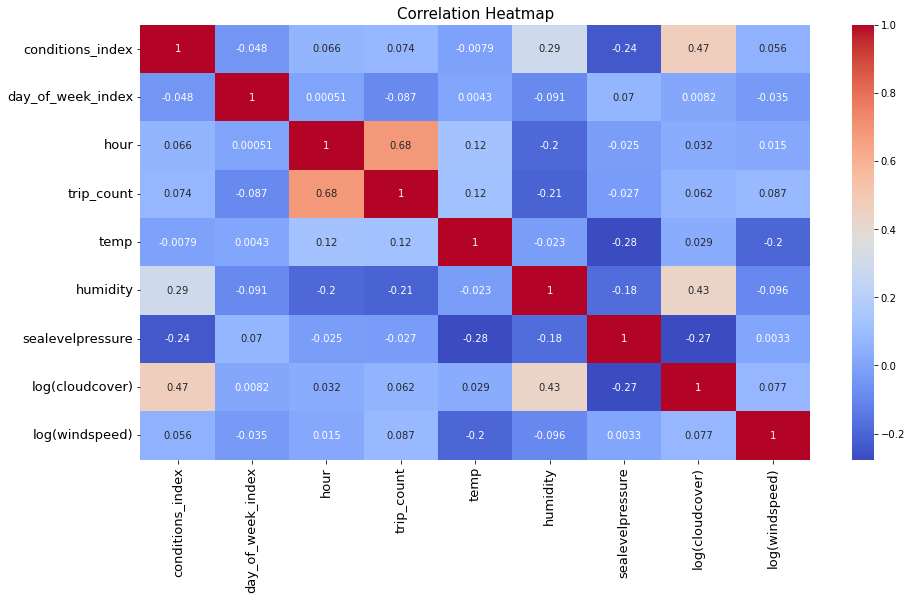

In [20]:
# Create a heatmap
plt.figure(figsize=(15, 8))
plt.title("Correlation Heatmap", fontsize=15)
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=feature_columns, yticklabels=feature_columns)
# Increase font size of feature labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=13)  # Adjust fontsize as needed
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=13) 

# Save the plot to an image file
output_image_path = "../plots/correlation of weathers.png"
plt.savefig(output_image_path)

plt.show()